# [CDAF] Atividade 6

## Nome: Thiago Pádua de Carvalho

## Matrícula: 2020007066

## Referências
- [1] https://www.ecmlpkdd2019.org/downloads/paper/701.pdf
- [2] https://dtai.cs.kuleuven.be/sports/blog/player-vectors:-characterizing-soccer-players'-playing-style
- [3] https://dtai.cs.kuleuven.be/sports/player_vectors
- [4] https://github.com/TomDecroos/matplotsoccer

## Introdução
- Nessa atividade, temos implementado o "Player Vectors", método proposto em [1] para caracterizar o estilo de jogo de jogadores baseado nas localizações que realizam cada tipo de ação.
- [2] apresenta o conteúdo do paper em [1] de forma mais resumida e visual, em formato de blog.
- [3] oferece uma demo interativa com uma aplicação do método no contexto de comparar a similaridade entre jogadores.
- [4] é uma biblioteca para plotar visualizações de partidas de futebol. Além disso, ela tem uma função pronta para criar heatmaps de ações de jogadores, que é util para o nosso contexto.

## Intruções
- Para cada header abaixo do notebook, vocês devem explicar o que foi feito e à qual seção/subseção/equação de [1] ela corresponde. Justifique suas respostas.
- Além disso, vocês devem montar um diagrama do fluxo de funções/tarefas de toda a pipeline do Player Vectors abaixo. Esse diagrama deve ser enviado como arquivo na submissão do Moodle, para além deste notebook.

### Carregando os dados

In [1]:
import numpy as np
import pandas as pd

In [2]:
def load_matches(path):
    matches = pd.read_json(path_or_buf=path)
    # as informações dos times de cada partida estão em um dicionário dentro da coluna 'teamsData', então vamos separar essas informações
    team_matches = []
    for i in range(len(matches)):
        team_match = pd.DataFrame(matches.loc[i, 'teamsData']).T
        team_match['matchId'] = matches.loc[i, 'wyId']
        team_matches.append(team_match)
    team_matches = pd.concat(team_matches).reset_index(drop=True)

    return matches, team_matches

In [3]:
def get_position(x):
    return x['name']

def load_players(path):
    players = pd.read_json(path_or_buf=path)
    players['player_name'] = players['firstName'] + ' ' + players['lastName']
    players['role'] = players['role'].apply(get_position)
    players = players[['wyId', 'player_name', 'role']].rename(columns={'wyId': 'player_id'})

    return players

In [4]:
def load_events(path):
    events = pd.read_json(path_or_buf=path)
    # pré processamento em colunas da tabela de eventos para facilitar a conversão p/ SPADL
    events = events.rename(columns={
        'id': 'event_id',
        'eventId': 'type_id',
        'subEventId': 'subtype_id',
        'teamId': 'team_id',
        'playerId': 'player_id',
        'matchId': 'game_id'
    })
    events['milliseconds'] = events['eventSec'] * 1000
    events['period_id'] = events['matchPeriod'].replace({'1H': 1, '2H': 2})

    return events

In [5]:
def load_minutes_played_per_game(path):
    minutes = pd.read_json(path_or_buf=path)
    minutes = minutes.rename(columns={
        'playerId': 'player_id',
        'matchId': 'game_id',
        'teamId': 'team_id',
        'minutesPlayed': 'minutes_played'
    })
    minutes = minutes.drop(['shortName', 'teamName', 'red_card'], axis=1)

    return minutes

In [6]:
leagues = ['England', 'Spain']
events = {}
matches = {}
team_matches = {}
game_minutes = {}
for league in leagues:
    path = f'../data/matches/matches_{league}.json'
    matches[league], team_matches[league] = load_matches(path)
    path = f'../data/events/events_{league}.json'
    events[league] = load_events(path)
    path = f'../data/minutes_played/minutes_played_per_game_{league}.json'
    game_minutes[league] = load_minutes_played_per_game(path)


In [7]:
path = f'../data/players.json'
players = load_players(path)
players['player_name'] = players['player_name'].str.decode('unicode-escape')

In [8]:
def calculate_minutes_per_season(minutes_per_game):
    minutes_per_season = minutes_per_game.groupby('player_id', as_index=False)['minutes_played'].sum()

    return minutes_per_season

#### O que foi feito
Primeiramente foi feito o carregamento de uma série de dados: jogos da La Liga e Premier League, jogadores, eventos e minutos jogados por jogo. Houve a leitura dos arquivos de dados em json e transformação em dataframes pandas, seguido de um pré processamento para facilitar a conversão em SPADL. Além disso, definiu-se a função calculate_minutes_per_season para computar o tempo em campo dos jogadores em cada temporada. Isso é de importância para a posterior normalização dos dados, que será feita por 90 minutos.



### SPADL

In [9]:
from tqdm import tqdm
import socceraction.spadl as spd

In [10]:
def spadl_transform(events, team_matches):
    spadl = []
    game_ids = events.game_id.unique().tolist()
    for g in tqdm(game_ids):
        match_events = events.loc[events.game_id == g]
        match_home_id = team_matches.loc[(team_matches.matchId == g) & (team_matches.side == 'home'), 'teamId'].values[0]
        match_actions = spd.wyscout.convert_to_actions(events=match_events, home_team_id=match_home_id)
        match_actions = spd.play_left_to_right(actions=match_actions, home_team_id=match_home_id)
        match_actions = spd.add_names(match_actions)
        spadl.append(match_actions)
    spadl = pd.concat(spadl).reset_index(drop=True)

    return spadl

In [11]:
spadl = {}
for league in leagues:
    spadl[league] = spadl_transform(events=events[league], team_matches=team_matches[league])

100%|██████████| 380/380 [02:44<00:00,  2.31it/s]


### O que foi feito
Após o processamento inicial dos dados, seguimos para a conversão dos mesmos para o formato SPADL. Para isso, foi criada uma função que recebe os dataframes de jogos e eventos, retornando um dataframe SPADL. Em seguidas chamamos a função dentro de um for para obtermos as ligas desejadas dentro de um dicionário spadl.

Tanto o pré processamento quanto a conversão para SPADL são cobertos na seção 2 - Data and Challenges. Especificamente o segundo é descrito brevemente em 2.1: Event Stream Data.

### Construção de Heatmaps

In [12]:
import scipy
import matplotsoccer as mps

In [13]:
def construct_heatmaps(spadl, season_minutes, action_type):
    heatmaps = {}
    if action_type == 'pass':
        heatmaps['start'] = {}
        heatmaps['end'] = {}
    for player_id in tqdm(season_minutes['player_id'].tolist()):
        mask = (spadl['player_id'] == player_id) & (spadl['type_name'] == action_type)
        player_actions = spadl[mask]
        if action_type != 'pass':
            heatmaps[player_id] = mps.count(x=player_actions['start_x'], y=player_actions['start_y'], n=25, m=16)
            heatmaps[player_id] *= (90 / season_minutes[season_minutes['player_id'] == player_id]['minutes_played'].values[0])
            heatmaps[player_id] = scipy.ndimage.gaussian_filter(heatmaps[player_id], 1)
        else:
            heatmaps['start'][player_id] = mps.count(x=player_actions['start_x'], y=player_actions['start_y'], n=25, m=16)
            heatmaps['start'][player_id] *= (90 / season_minutes[season_minutes['player_id'] == player_id]['minutes_played'].values[0])
            heatmaps['start'][player_id] = scipy.ndimage.gaussian_filter(heatmaps['start'][player_id], 1)
            heatmaps['end'][player_id] = mps.count(x=player_actions['end_x'], y=player_actions['end_y'], n=25, m=16)
            heatmaps['end'][player_id] *= (90 / season_minutes[season_minutes['player_id'] == player_id]['minutes_played'].values[0])
            heatmaps['end'][player_id] = scipy.ndimage.gaussian_filter(heatmaps['end'][player_id], 1)

    return heatmaps

In [14]:
season_minutes = {}
for league in leagues:
    season_minutes[league] = calculate_minutes_per_season(minutes_per_game=game_minutes[league])
    mask = (season_minutes[league]['minutes_played'] >= 900) & (season_minutes[league]['player_id'].isin(players.loc[players['role'] != 'Goalkeeper', 'player_id']))
    season_minutes[league] = season_minutes[league][mask]

In [15]:
action_types = ['shot', 'pass', 'cross', 'dribble']
heatmaps = {}
for league in leagues:
    heatmaps[league] = {}
    for at in action_types:
        heatmaps[league][at] = construct_heatmaps(spadl=spadl[league], season_minutes=season_minutes[league], action_type=at)

100%|██████████| 324/324 [00:08<00:00, 40.49it/s]


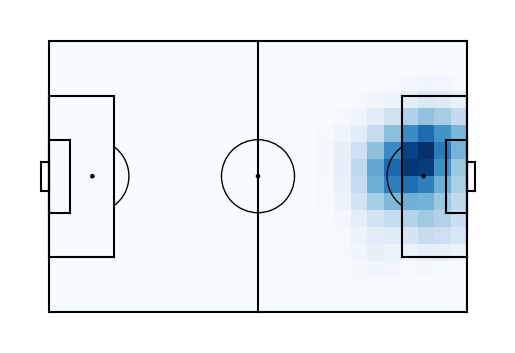

<Axes: >

In [16]:
mps.heatmap(heatmaps['Spain']['shot'][3359])

### O que foi feito
Nesse trecho de código é feita a construção de heatmaps para cada liga, conforme descrito na seção 4.2 do paper. Para isso, foi criada uma função que recebe um dataframe SPADL e retorna um dicionário com os heatmaps todos os jogadores. Em seguida, foi chamada a função para cada liga dentro de um for, retornando um dicionário de ligas contendo dicionários de tipos de ações.

Por fim, o heatmap de chutes na liga espanhola é plotado para iustrar o resultado.

### Comprimindo heatmaps para vetores

In [17]:
def heatmaps_to_vectors(heatmaps, action_type):
    if action_type != 'pass':
        vectorized_heatmaps = np.array([heatmaps[player_id].reshape(-1) for player_id in heatmaps.keys()])
    else:
        vectorized_heatmaps = np.array([np.concatenate([heatmaps['start'][player_id].reshape(-1), heatmaps['end'][player_id].reshape(-1)]) for player_id in heatmaps['start'].keys()])

    return vectorized_heatmaps

In [18]:
vectorized_heatmaps = {}
for league in leagues:
    vectorized_heatmaps[league] = {}
    for act_type in action_types:
        vectorized_heatmaps[league][act_type] = heatmaps_to_vectors(heatmaps=heatmaps[league][act_type], action_type=act_type)

### O que foi feito
Uma vez montados os heatmaps, partimos para comprimí-los para vetores (seção 4.3 -
Compressing Heatmaps to Vectors). Para isso, comprimimos cada heatmap para um vetor de comprimento m*n, onde m é o número de linhas e n o número de colunas do grid montado sobre o campo. A partir disso construímos uma matriz cujas colunas são os vetores descritos.

### NMF (non-negative matrix factorization)

In [19]:
from sklearn.decomposition import NMF

In [20]:
def nmf_decomposition(vectorized_heatmaps, n_components):
    nmf = NMF(n_components=n_components, init='nndsvda', random_state=0)
    nmf.fit(vectorized_heatmaps)

    return nmf

In [21]:
n_components = {'shot': 4, 'pass': 5, 'cross': 4, 'dribble': 5}
concat_vectors = {}
nmfs = {}
for act_type in action_types:
    concat_vectors[act_type] = np.concatenate([vectorized_heatmaps['England'][act_type], vectorized_heatmaps['Spain'][act_type]])
    nmfs[act_type] = nmf_decomposition(vectorized_heatmaps=concat_vectors[act_type], n_components=n_components[act_type])

### O que foi feito
Conforme descrito na seção 4 - Building Player Vectors, uma vez que remodelamos as matrizes obtidas por ação por jogador em vetores e agrupamos por tipo de ação, obtendo matrizes grandes, que descrevem o estilo de jogo de todos os jogadores para aquele tipo específico de ação, devemos aplicar o NMF. Essa técnica é utilizada para reduzir a dimensionalidade dos dados, de forma que possamos obter uma representação mais compacta dos mesmos.

O que obtemos são matrizes W e H cuja multiplicação aproxima a matriz original. A matriz W é a matriz de características, que descreve o estilo de jogo de cada jogador. A matriz H é a matriz de pesos, que descreve a importância de cada característica para cada tipo de ação.

### Reconstruction Evaluation

In [22]:
for act_type in action_types:
    print('{} Reconstruction evaluation\n'.format(act_type))
    print('Reconstruction error from NMF object: {}'.format(nmfs[act_type].reconstruction_err_))
    reconst_vectors = np.dot(nmfs[act_type].components_.T, nmfs[act_type].transform(concat_vectors[act_type]).T).T
    reconst_error = np.sqrt(np.sum((concat_vectors[act_type] - reconst_vectors) ** 2))
    print('Manual reconstruction error: {}'.format(reconst_error))
    print('Mean reconstruction error: {}'.format(reconst_error / (concat_vectors[act_type].shape[1])))
    print('--------------------------------\n')

shot Reconstruction evaluation

Reconstruction error from NMF object: 1.3224879226321518
Manual reconstruction error: 1.3224879184800893
Mean reconstruction error: 0.0033062197962002234
--------------------------------

pass Reconstruction evaluation

Reconstruction error from NMF object: 28.196261893627756
Manual reconstruction error: 28.196261647153566
Mean reconstruction error: 0.035245327058941955
--------------------------------

cross Reconstruction evaluation

Reconstruction error from NMF object: 2.3365384800195814
Manual reconstruction error: 2.336538445866538
Mean reconstruction error: 0.005841346114666345
--------------------------------

dribble Reconstruction evaluation

Reconstruction error from NMF object: 4.008096593968764
Manual reconstruction error: 4.008096580590021
Mean reconstruction error: 0.010020241451475051
--------------------------------



### O que foi feito
Como descrito anteriormente, o uso da técnica de NMF visa reduzir a dimensionalidade dos dados. Isso nos retorna uma aproximação da matriz original(M) separada em dois componentes: W e H. Aqui foi avaliada a qualidade de reconstrução de M para cada tipo de ação.

### Deanonymization Evaluation

In [23]:
matches_1st = {}
matches_2nd = {}
spadl_1st = {}
spadl_2nd = {}
season_minutes_1st = {}
season_minutes_2nd = {}
for league in leagues:
    matches[league] = matches[league].sort_values(by='dateutc').reset_index(drop=True)
    matches_1st[league] = matches[league].loc[: int(len(matches[league]) / 2) - 1, 'wyId'].values.tolist()
    matches_2nd[league] = matches[league].loc[int(len(matches[league]) / 2) :, 'wyId'].values.tolist()
    season_minutes_1st[league] = calculate_minutes_per_season(game_minutes[league][game_minutes[league]['game_id'].isin(matches_1st[league])])
    season_minutes_2nd[league] = calculate_minutes_per_season(game_minutes[league][game_minutes[league]['game_id'].isin(matches_2nd[league])])
    season_minutes_1st[league] = season_minutes_1st[league][season_minutes_1st[league]['minutes_played'] >= 900]
    season_minutes_2nd[league] = season_minutes_2nd[league][season_minutes_2nd[league]['minutes_played'] >= 900]
    season_minutes_1st[league] = season_minutes_1st[league][season_minutes_1st[league]['player_id'].isin(season_minutes_2nd[league]['player_id'])]
    season_minutes_2nd[league] = season_minutes_2nd[league][season_minutes_2nd[league]['player_id'].isin(season_minutes_1st[league]['player_id'])]
    mask_1st = (spadl[league]['game_id'].isin(matches_1st[league])) & (spadl[league]['player_id'].isin(season_minutes_1st[league]['player_id']))
    spadl_1st[league] = spadl[league][mask_1st]
    mask_2nd = (spadl[league]['game_id'].isin(matches_2nd[league])) & (spadl[league]['player_id'].isin(season_minutes_2nd[league]['player_id']))
    spadl_2nd[league] = spadl[league][mask_2nd]

In [24]:
heatmaps_1st = {}
heatmaps_2nd = {}
for league in leagues:
    heatmaps_1st[league] = {}
    heatmaps_2nd[league] = {}
    for at in action_types:
        heatmaps_1st[league][at] = construct_heatmaps(spadl=spadl_1st[league], season_minutes=season_minutes_1st[league], action_type=at)
        heatmaps_2nd[league][at] = construct_heatmaps(spadl=spadl_2nd[league], season_minutes=season_minutes_2nd[league], action_type=at)

100%|██████████| 154/154 [00:01<00:00, 116.75it/s]


In [25]:
vectorized_heatmaps_1st = {}
vectorized_heatmaps_2nd = {}
for league in leagues:
    vectorized_heatmaps_1st[league] = {}
    vectorized_heatmaps_2nd[league] = {}
    for act_type in action_types:
        vectorized_heatmaps_1st[league][act_type] = heatmaps_to_vectors(heatmaps=heatmaps_1st[league][act_type], action_type=act_type)
        vectorized_heatmaps_2nd[league][act_type] = heatmaps_to_vectors(heatmaps=heatmaps_2nd[league][act_type], action_type=act_type)

In [26]:
def coefficients_transform(vectorized_heatmaps, nmf):
    return nmf.transform(vectorized_heatmaps)

In [27]:
vectorized_coefs_1st = {}
vectorized_coefs_2nd = {}
for league in leagues:
    vectorized_coefs_1st[league] = {}
    vectorized_coefs_2nd[league] = {}
    for act_type in action_types:
        vectorized_coefs_1st[league][act_type] = coefficients_transform(vectorized_heatmaps=vectorized_heatmaps_1st[league][act_type], nmf=nmfs[act_type])
        vectorized_coefs_2nd[league][act_type] = coefficients_transform(vectorized_heatmaps=vectorized_heatmaps_2nd[league][act_type], nmf=nmfs[act_type])

In [28]:
player_vectors_1st = {}
player_vectors_2nd = {}
for league in leagues:
    player_vectors_1st[league] = np.concatenate([vectorized_coefs_1st[league][act_type] for act_type in action_types], axis=1)
    player_vectors_2nd[league] = np.concatenate([vectorized_coefs_2nd[league][act_type] for act_type in action_types], axis=1)

In [29]:
player_vectors_1st = np.concatenate([player_vectors_1st[league] for league in leagues])
player_vectors_2nd = np.concatenate([player_vectors_2nd[league] for league in leagues])

In [30]:
player_ids = []
for league in leagues:
    player_ids += list(heatmaps_1st[league]['shot'].keys())

In [31]:
from sklearn.metrics import pairwise_distances

In [32]:
D = pairwise_distances(player_vectors_1st, player_vectors_2nd, metric="manhattan")

# sort each row
# k_d = np.sort(D, axis=1)
# sort each row and replace distances by index
k_i = np.argsort(D, axis=1)
# replace indices by player ids
p_i = np.take(player_ids, k_i, axis=0)

rs = np.argmax(np.array([p_i[i, :] == player_ids[i] for i in range(p_i.shape[0])]), axis=1)

def mean_reciprocal_rank(rs):
    return np.mean(1. / (rs + 1))

def top_k(rs, k):
    return (rs < k).sum() / len(rs)

mrr = mean_reciprocal_rank(rs)
top1 = top_k(rs, 1)
top3 = top_k(rs, 3)
top5 = top_k(rs, 5)
top10 = top_k(rs, 10)

In [33]:
print('Top 1 = {}%'.format(round(top1 * 100, 1)))
print('Top 3 = {}%'.format(round(top3 * 100, 1)))
print('Top 5 = {}%'.format(round(top5 * 100, 1)))
print('Top 10 = {}%'.format(round(top10 * 100, 1)))
print('MRR = {}'.format(round(mrr, 3)))

Top 1 = 38.3%
Top 3 = 61.4%
Top 5 = 70.5%
Top 10 = 81.9%
MRR = 0.532


### O que foi feito
Nesse trecho foram aplicadas as técnicas definidas no paper e suas funções correspondentes aqui construídas e descritas. Trata-se de uma avaliação similar à realizada na seção 5.4 - Player Retrieval from Anonymized Match Event Stream Data.

Nesse sentido foram construidos os heatmaps e seus respectivos vetores a partir das ações de todos os jogadores, feito o NMF e, então, construídos os vetores de características de cada jogador. Em seguida, obtemos uma série de ações anônimas e novamente construímos vetores de jogadores. Por fim comparamos os dois tipos de vetores e rankeamos os jogadores mais similares.

Apresentamos os resultados finais em termos de similaridade com os topos dos rankings para cada jogador e também o MRR (Mean Reciprocal Rank) para cada liga.

### Explore Similar Players

In [34]:
vectorized_coefs = {}
for league in leagues:
    vectorized_coefs[league] = {}
    for act_type in action_types:
        vectorized_coefs[league][act_type] = coefficients_transform(vectorized_heatmaps=vectorized_heatmaps[league][act_type], nmf=nmfs[act_type])

In [35]:
player_vectors = {}
for league in leagues:
    player_vectors[league] = np.concatenate([vectorized_coefs[league][act_type] for act_type in action_types], axis=1)

In [36]:
player_vectors = np.concatenate([player_vectors[league] for league in leagues])

In [37]:
player_ids = []
for league in leagues:
    player_ids += list(heatmaps[league]['shot'].keys())

In [38]:
D = pairwise_distances(player_vectors, player_vectors, metric="manhattan")
# sort each row
# k_d = np.sort(D, axis=1)
# sort each row and replace distances by index
k_i = np.argsort(D, axis=1)
# replace indices by player ids
p_i = np.take(player_ids, k_i, axis=0)

In [39]:
similar_players = pd.DataFrame(data=p_i[:, : 11], columns=['player_id'] + ['{}th_similar'.format(i) for i in range(1, 11)])

In [40]:
players = players[players['player_id'].isin(similar_players['player_id'])].reset_index(drop=True)

In [41]:
id_to_name = {}
for i in range(len(players)):
    id_to_name[players.loc[i, 'player_id']] = players.loc[i, 'player_name']

In [42]:
similar_players = similar_players.replace(id_to_name)

In [44]:
similar_players

,player_id,1th_similar,2th_similar,3th_similar,4th_similar,5th_similar,6th_similar,7th_similar,8th_similar,9th_similar,10th_similar
0,Toby Alderweireld,Aïssa Mandi,David López Silva,Raphaël Varane,Gerard Piqué Bernabéu,Aritz Elustondo Irribaria,Unai Núñez Gestoso,Ezequiel Marcelo Garay,Jack Stephens,Facundo Sebastián Roncaglia,Daniele Bonera
1,Jan Vertonghen,Samuel Yves Umtiti,Zouhair Feddal,Íñigo Martínez Berridi,Wesley Hoedt,Clément Lenglet,Aymeric Laporte,Anaitz Arbilla Zabala,Pedro Bigas Rigo,Sergio Ramos García,Antonio Rüdiger
2,Christian Dannemann Eriksen,Mesut Özil,Kevin De Bruyne,Henrikh Mkhitaryan,Jesse Lingard,Francesc Fàbregas i Soler,Joan Jordán Moreno,Aaron Ramsey,Alex Pritchard,Pablo Fornals Malla,Paul Pogba
3,Ragnar Klavan,Andreu Fontàs Prat,Pedro Bigas Rigo,Thomas Vermaelen,Víctor Ruíz Torre,Sergio Ramos García,Alfie Mawson,Jeison Fabián Murillo Cerón,Clément Lenglet,Zouhair Feddal,Aymeric Laporte
4,Johann Berg Guðmunds­son,Matt Ritchie,Andros Townsend,David Remeseiro Salgueiro,Julián Omar Ramos Suárez,Michail Antonio,Theo Walcott,Ibai Gómez Pérez,Markel Susaeta Laskurain,Aaron Lennon,Sergio Gontán Gallardo
...,...,...,...,...,...,...,...,...,...,...,...
628,Roberto Suárez Pier,Ahmed Hegazy,Martín Maximiliano Mantovani,Bruno González Cabrera,Scott Dann,Rodrigo Ely,Alexis Ruano Delgado,James Tomkins,David Rodríguez Lombán,Ashley Williams,Claudio Ariel Yacob
629,Daniel Raba Antolí,Riyad Mahrez,Brais Méndez Portela,André Martín Carrillo Díaz,Carlos Soler Barragán,Xherdan Shaqiri,Anthony Knockaert,Ángel Martín Correa,Jordon Ibe,Sergio Gontán Gallardo,Andros Townsend
630,Oghenekaro Etebo,Harry Arter,Etienne Capoue,Mario Lemina,Álvaro Medrán Just,Jefferson Andrés Lerma Solís,Mikel Merino Zazón,Geoffrey Kondogbia,Igor Zubeldía Elorza,Andrew Surman,Idrissa Gana Gueye
631,Youssef En-Nesyri,Dwight Gayle,Munir El Haddadi Mohamed,Jonathan Calleri,Manolo Gabbiadini,José Salomón Rondón Giménez,Aritz Aduriz Zubeldia,Cenk Tosun,Carlos Arturo Bacca Ahumada,Troy Deeney,Jamie Vardy


### O que foi feito
Usando as técnicas apresentadas até aqui foi possível construir uma tabela que, para cada jogador, fornece um ranking com aqueles cujo estilo de jogo mais se aproxima.
Como visto na seção 5.2 - Scouting, essa tabela pode ser usada para encontrar jogadores com estilos de jogo similares àqueles desejados por um clube com fins de contratação.
Além disso, esse tipo de dado pode ser usado para avaliar a performance de um jogador em relação àqueles com estilos de jogo similares, como visto na seção 5.3. Outro tipo de uso é na preparação para jogos, na qual os técnicos podem identificar as qualidade de seus adversários, tal como fraquezas do seu time e planejar suas estratégias de acordo com os estilos de jogo apresentados por seus atletas e oponentes.